In [1]:
# coding:utf-8
import sys

class ProgressBar():

    def __init__(self, max_steps):
        self.max_steps = max_steps
        self.current_step = 0
        self.progress_width = 50

    def update(self, step=None):
        self.current_step = step

        num_pass = int(self.current_step * self.progress_width / self.max_steps) + 1
        num_rest = self.progress_width - num_pass 
        percent = (self.current_step+1) * 100.0 / self.max_steps 
        progress_bar = '[' + '■' * (num_pass-1) + '▶' + '-' * num_rest + ']'
        progress_bar += '%.2f' % percent + '%' 
        if self.current_step < self.max_steps - 1:
            progress_bar += '\r' 
        else:
            progress_bar += '\n' 
        sys.stdout.write(progress_bar) 
        sys.stdout.flush()
        if self.current_step >= self.max_steps:
            self.current_step = 0
            print

# Lemmatization et Tokenization

In [2]:
import json
import re
import numpy as np
from pprint import pprint
import pandas as pd
import requests
import nltk.data
import matplotlib.pyplot as plt
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

In [3]:
class JSONObject:
     def __init__(self, d):
         self.__dict__ = d

In [4]:
with open("articles_Accuracy.json", "r") as read_file:
    data = read_file.read()
    obj = json.loads(data,object_hook=JSONObject)

In [ ]:
len(obj)

In [ ]:
print(obj[1].__dict__)

In [5]:
## stopword dictionary
from nltk.corpus import stopwords
stopworddic = set(stopwords.words('french'))
stopwordeng = set(stopwords.words('english'))
article=['a','au','aux','un','une','le','la','les','de','du','des','ce','cet','cette','ces','son','sa','ses','leur','leurs','mon','ma','mes','ton','ta','tes','notre','notres','votre','votres']
pronom=['où','dont','ça','je','tu','il','elle','nous','vous','ils','elles','on','y','en','se','que','qui','quoi','comment','quand','pourquoi']
coordination=['mais','ou','et','donc','or','ni','car','ne']
v=['avoir','aller','être','faire','pouvoir','doit','devon']
prop=['selon','outre','après','dans','sur','dessus','sous','chez','hors','à','dehors','devant','derrière','avant','arrière','par','entre','parmi','avec','ici','là','bas','pour','pendant','depuis','voilà','dès','aussitôt']
adv=['pas','rien','personne','plus','aucun','jamais','nul','aussi','déjà','moins','comme']
conj=['comme','si','lorsque','tel','mais','parce']
n=['fait','an']
english=['of','and','or']
stopword1=['coworking', 'co-working',  'incubateur', 'couveuse', 'pépinière', 'start-up', 'startup', 'accélérateur', 'jeune', 'pousse', 'fablab', 'entreprise', 'studio']
stopword2=['projet','innovation','entrepreneur','grand']
stopworddic.update(set(article),set(pronom),set(coordination),set(v),set(prop),set(adv),set(conj),set(n),set(stopword1),set(stopword2),set(stopwordeng))

In [6]:
## lemmatization
lemmatizer = FrenchLefffLemmatizer()
def lemma(word):
    a=lemmatizer.lemmatize(word,'all')
    b=[x[1] for x in a]
    if 'nc' in b:
        return lemmatizer.lemmatize(word,'n')
    if 'v' in b:
        return lemmatizer.lemmatize(word,'v')
    return lemmatizer.lemmatize(word)

In [7]:
## tokenization
def tokenize(article):
    rawtokens=nltk.word_tokenize(article)
    metokens = [w.lower() for w in rawtokens if re.search('[a-zA-ZàâäèéêëîïôœùûüÿçÀÂÄÈÉÊËÎÏÔŒÙÛÜŸÇ]+',w)]
    latokens=[]
    for str in metokens:
        if(re.search(r'\w+\'',str)):
            str=re.sub(r'\w+\'', '', str) 
        latokens.append(str)

    tokens = [w for w in latokens if w not in stopworddic]
    tokens = [lemma(w) for w in tokens]
    tokens = [w for w in tokens if w not in stopworddic]
    
    return tokens

In [8]:
token_text=[]
for doc in obj:
    if len(doc.body_fr)>2:
        token_text.append(tokenize(doc.body_fr))
        
from collections import defaultdict
frequency = defaultdict(int)

for text in token_text :
    for token in text :
        frequency[token]+=1
        
token_text = [[token for token in text if frequency[token] >= 5] for text in token_text]

# LDA

## Classification

In [9]:
from gensim import corpora, models
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import LdaModel

In [21]:
dictionary = corpora.Dictionary(token_text)
corpus = [dictionary.doc2bow(text) for text in token_text]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [23]:
dictionary.save('dictionary.dict')
corpora.MmCorpus.serialize('corpus.mm', corpus_tfidf)

In [24]:
for num in range(6,11):
    lda = models.ldamodel.LdaModel(corpus_tfidf, id2word = dictionary, num_topics = num)
    lda.save('lda'+str(num)+'.model')
    print('lda'+str(num)+' saved')

lda6 saved
lda7 saved
lda8 saved
lda9 saved
lda10 saved


In [93]:
num=14
lda = models.ldamodel.LdaModel(corpus_tfidf, id2word = dictionary, num_topics = num)
lda.save('lda'+str(num)+'.model')
print('lda'+str(num)+' saved')

lda14 saved


# LDA + Word2Vec

## Word2Vec

In [ ]:
from gensim.models import word2vec

In [ ]:
# train word2vec
model=word2vec.Word2Vec(token_text, size=50)
model.save('word2vec.txt')

In [ ]:
model = word2vec.Word2Vec.load('word2vec.txt')

In [77]:
model.wv.most_similar('politique')

[('politiques', 0.8066859245300293),
 ('dialogue', 0.772895336151123),
 ('réforme', 0.7713379859924316),
 ('importance', 0.7568222284317017),
 ('priorité', 0.7523826360702515),
 ('faveur', 0.745557427406311),
 ('mobilisation', 0.7387747168540955),
 ('contexte', 0.7357494831085205),
 ('volontariste', 0.7301435470581055),
 ('effort', 0.7240047454833984)]

In [84]:
model.wv.similarity('chine','inde')

0.858529

In [ ]:
# convert topic generated by lda to vec
def Topic2Vec(topic_list, model):
    topic = np.array(topic_list)
    wordvec = model.wv[topic[:,0]]
    prob = topic[:,1].astype(float)
    prob = prob/prob.sum()
    return prob.dot(wordvec) # dimension 50*1

# convert document to vec
def Doc2Vec(doc, model):
    return model.wv[np.array(doc)].mean(axis=0) # dimension 50*1

# compare similarity between two vecs
def Vec_similarity(tvec,dvec):
    return tvec.dot(dvec)/(np.linalg.norm(tvec)*np.linalg.norm(dvec))

# decide the topic of one document
def Doc2Topic(token, lda, num, model):
    D_Vec = Doc2Vec(token, model)
    prob = [Vec_similarity(Topic2Vec(lda.show_topic(i,topn=20), model),D_Vec) for i in range(num)]
    return np.argmax(prob)

## Distribution of topic of each text

In [ ]:
import numpy as np

num = 6
loading = LdaModel.load('lda'+str(num)+'.model')
dictionary = gensim.corpora.Dictionary.load('dictionary.dict')
corpus_tfidf = gensim.corpora.MmCorpus('corpus.mm')

#t = np.array(loading[corpus_tfidf[0]])
#plt.stem(t[:,0],t[:,1])
#print(t[:,1])
#plt.show()


for i in range(20):
    t = np.array(loading[corpus_tfidf[i]])
    plt.stem(t[:,0],t[:,1])
    print("text Nr",i)
    print(t[:,1])
    plt.show()

In [66]:
def Nrtopic(t):
    N = 0
    for i in t:
        if (i[1]>0.1):
            N=N+1
    return N

def relation_num_topic_per_document(thetas,num):
    plt.hist([Nrtopic(t) for t in thetas], range(num+1))
    plt.ylabel('Nr of documents')
    plt.xlabel('Nr of topics')
    plt.savefig('result'+str(num)+'_TD.pdf')
    plt.show()
    
def relation_num_document_per_topic(thetas,num):
    n_doc = np.zeros(num).astype(int)
    for prob_dis in thetas:
        #prob_topic = prob_dis[prob_dis[:,1]>1./num][:,0].astype(int)
        prob_topic = np.argmax(prob_dis[:,1])
        n_doc[prob_topic] += 1
    
    for i in range(num):
        color = plt.cm.Spectral(float(i) / num)  # 搞一款颜色
       
        plt.bar(i, n_doc[i], align='center', color = color)
        plt.text(i-0.25, n_doc[i] + 10, str(n_doc[i]))
    
    plt.title('The quantity of documents for {} topics(LDA)'.format(num))
    plt.ylabel('Nr of documents')
    plt.xlabel('Index of topics')
    plt.savefig('result'+str(num)+'_DT.pdf')
    plt.show()
    return n_doc

def relation_num_document_per_topic_w2v(loading,num):
    num_Topic = np.zeros(num)
    progress_bar = ProgressBar(len(token_text))
    i = 0
    for token in token_text:
        if len(token)>0:
            num_Topic[Doc2Topic(token, loading, num, model)]+=1
        progress_bar.update(i)
        i += 1
    num_Topic = num_Topic.astype(int)
        
    for i in range(num):
        color = plt.cm.Spectral(float(i) / num)  # 搞一款颜色
        plt.bar(i, num_Topic[i], align='center', color = color)
        plt.text(i-0.25, num_Topic[i] + 10, str(num_Topic[i]))
        
    plt.title('The quantity of documents for {} topics(W2V)'.format(num))
    plt.ylabel('Nr of documents')
    plt.xlabel('Index of topics')
    plt.savefig('result'+str(num)+'_WV.pdf')
    plt.show()

In [91]:
loading = LdaModel.load('lda7.model')
topic = np.array(loading.show_topic(5))
topic

array([['pari', '0.0012343883'],
       ['fintech', '0.0011416551'],
       ['donnée', '0.0011334069'],
       ['ville', '0.0011088194'],
       ['banque', '0.0010276946'],
       ['million', '0.0010020535'],
       ['espace', '0.0009958986'],
       ['luxembourg', '0.0009891345'],
       ['service', '0.00094812695'],
       ['nouveau', '0.00094792456']], dtype='<U13')

Num_topic : 6
Topic #0: 0.001*"sap" + 0.001*"swave" + 0.001*"village" + 0.001*"technologie" + 0.001*"fintech" + 0.001*"numérique" + 0.001*"chain" + 0.001*"niort" + 0.001*"monaco" + 0.001*"paygreen" + 0.001*"ca" + 0.001*"recast.ai" + 0.001*"développement" + 0.001*"financier" + 0.001*"accelerator" + 0.001*"claroty" + 0.001*"finance" + 0.001*"groupe"
Topic #1: 0.001*"client" + 0.001*"espace" + 0.001*"nouveau" + 0.001*"euro" + 0.001*"créer" + 0.001*"numérique" + 0.001*"solution" + 0.001*"france" + 0.001*"service" + 0.001*"produit" + 0.001*"fonds" + 0.001*"proposer" + 0.001*"permettre" + 0.001*"réseau" + 0.001*"région" + 0.001*"startups" + 0.001*"pari" + 0.001*"tout"
Topic #2: 0.004*"heure" + 0.001*"samedi" + 0.001*"contact" + 0.001*"rue" + 0.001*"permanence" + 0.001*"responsable" + 0.001*"mai" + 0.001*"organiser" + 0.001*"salle" + 0.001*"juin" + 0.001*"association" + 0.001*"cci" + 0.001*"espace" + 0.001*"groupe" + 0.001*"vendredi" + 0.001*"ecole" + 0.001*"bordeaux" + 0.001*"dimanche"
Topic

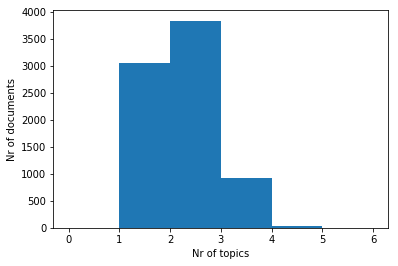

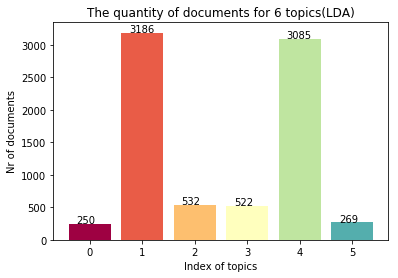

[■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■▶]100.00%


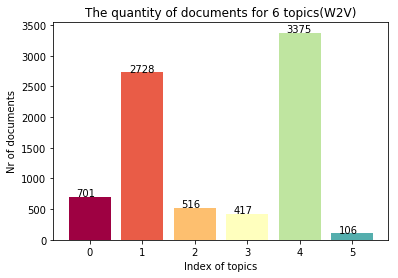

coherence : 0.42979387824966975
Num_topic : 7
Topic #0: 0.004*"médiation" + 0.004*"victime" + 0.004*"17h" + 0.003*"indre" + 0.003*"12h" + 0.002*"adavim" + 0.002*"adavimawanadoo.fr" + 0.002*"droit" + 0.002*"nécrologiques" + 0.002*"aide" + 0.002*"carnetanr-communication.fr" + 0.002*"châteauroux" + 0.002*"accès" + 0.002*"courriel" + 0.002*"8h30" + 0.002*"départementale" + 0.002*"mail" + 0.002*"tél"
Topic #1: 0.002*"heure" + 0.001*"numérique" + 0.001*"formation" + 0.001*"pari" + 0.001*"nouveau" + 0.001*"professionnel" + 0.001*"espace" + 0.001*"créer" + 0.001*"travail" + 0.001*"rue" + 0.001*"deux" + 0.001*"société" + 0.001*"contact" + 0.001*"france" + 0.001*"client" + 0.001*"proposer" + 0.001*"tout" + 0.001*"école"
Topic #2: 0.002*"salmane" + 0.002*"prince" + 0.001*"arabie" + 0.001*"saoudite" + 0.001*"ben" + 0.001*"héritier" + 0.001*"tunisie" + 0.001*"mbs" + 0.001*"synergie" + 0.001*"moroccan" + 0.001*"pari" + 0.001*"touch" + 0.001*"marocain" + 0.001*"french" + 0.001*"tapisserie" + 0.001*"s

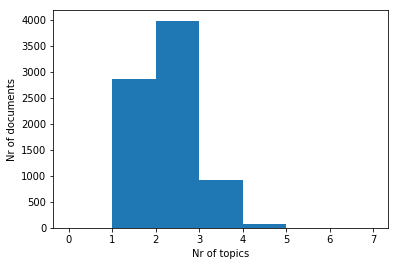

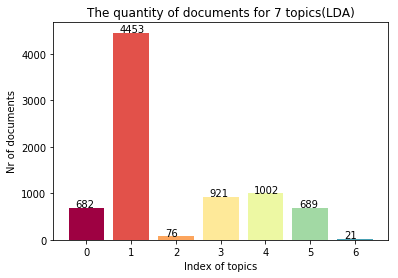

[■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■▶]100.00%


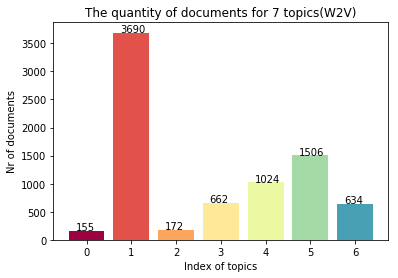

coherence : 0.4342128340643067
Num_topic : 8
Topic #0: 0.001*"forbach" + 0.001*"eur" + 0.001*"travel" + 0.001*"salmane" + 0.001*"news" + 0.001*"anjou" + 0.001*"ben" + 0.001*"eurodev" + 0.001*"center" + 0.001*"n26" + 0.001*"reserved" + 0.001*"rights" + 0.001*"provence" + 0.001*"tf1" + 0.001*"linxo" + 0.001*"france" + 0.001*"angers" + 0.001*"coworkers"
Topic #1: 0.003*"médiation" + 0.003*"victime" + 0.003*"17h" + 0.003*"indre" + 0.002*"12h" + 0.002*"adavim" + 0.002*"droit" + 0.002*"adavimawanadoo.fr" + 0.002*"aide" + 0.002*"accès" + 0.002*"nécrologiques" + 0.002*"châteauroux" + 0.002*"courriel" + 0.002*"carnetanr-communication.fr" + 0.001*"départementale" + 0.001*"mail" + 0.001*"permanence" + 0.001*"8h30"
Topic #2: 0.001*"chine" + 0.001*"mohammed" + 0.001*"mbs" + 0.001*"macron" + 0.001*"caler" + 0.001*"arabie" + 0.001*"monaco" + 0.001*"saoudien" + 0.001*"saoudite" + 0.001*"chinois" + 0.001*"cook" + 0.001*"agromousquetaires" + 0.001*"emmanuel" + 0.001*"auray" + 0.001*"pari" + 0.001*"techn

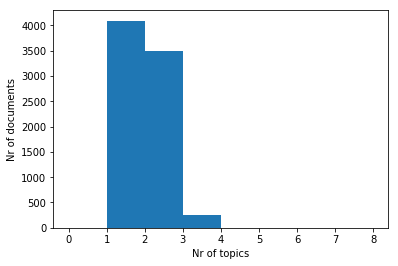

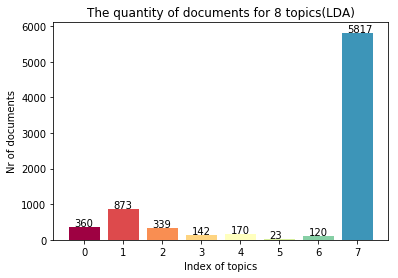

[■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■▶]100.00%


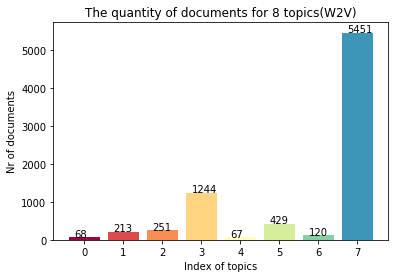

coherence : 0.4768572807319039
Num_topic : 9
Topic #0: 0.002*"sc" + 0.002*"lp" + 0.001*"quéré" + 0.001*"travel" + 0.001*"provence" + 0.001*"douarnenez" + 0.001*"gauthier" + 0.001*"josselin" + 0.001*"klanik" + 0.001*"valérie-noëlle" + 0.001*"kodjo" + 0.001*"virginie" + 0.001*"diop" + 0.001*"ivry" + 0.001*"seedstars" + 0.001*"porcelaine" + 0.001*"auchan" + 0.001*"créatis"
Topic #1: 0.001*"e=" + 0.001*"r=9chkp3bakplifptles8oeribuqorq1cnygcyl5qe3rm" + 0.001*"//urldefense.proofpoint.com/v2/url" + 0.001*"d=dwmgaq" + 0.001*"c=sfymryylsugfxnyao2svzg" + 0.001*"https" + 0.001*"heure" + 0.001*"microsoft" + 0.001*"client" + 0.001*"tunisie" + 0.001*"ia" + 0.001*"station" + 0.001*"groupe" + 0.001*"français" + 0.001*"luxembourg" + 0.001*"donnée" + 0.001*"f" + 0.001*"france"
Topic #2: 0.002*"bordeaux" + 0.002*"numérique" + 0.001*"heure" + 0.001*"nouvelle-aquitaine" + 0.001*"basque" + 0.001*"logement" + 0.001*"airbnb" + 0.001*"territoire" + 0.001*"gironde" + 0.001*"emploi" + 0.001*"ville" + 0.001*"rése

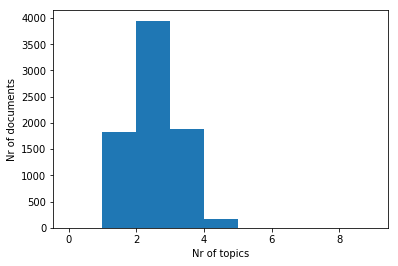

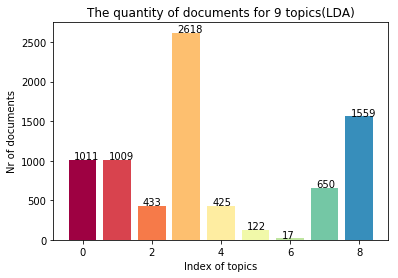

[■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■▶]100.00%


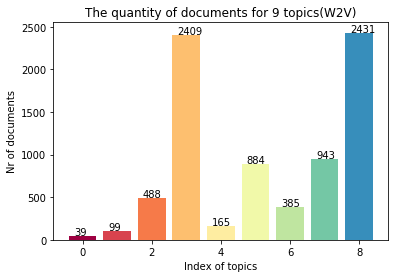

coherence : 0.4241733920009908
Num_topic : 10
Topic #0: 0.001*"numérique" + 0.001*"heure" + 0.001*"euro" + 0.001*"territoire" + 0.001*"nouveau" + 0.001*"espace" + 0.001*"ville" + 0.001*"président" + 0.001*"site" + 0.001*"région" + 0.001*"tech" + 0.001*"formation" + 0.001*"développement" + 0.001*"commune" + 0.001*"travail" + 0.001*"bâtiment" + 0.001*"étudiant" + 0.001*"cci"
Topic #1: 0.002*"niort" + 0.001*"gmt" + 0.001*"cook" + 0.001*"agromousquetaires" + 0.001*"leonard" + 0.001*"var-matin" + 0.001*"nice-matin" + 0.001*"newsletter" + 0.001*"angers" + 0.001*"commune" + 0.001*"vitré" + 0.001*"heure" + 0.001*"taxe" + 0.001*"sem" + 0.001*"inscription" + 0.001*"vinci" + 0.001*"budget" + 0.001*"communauté"
Topic #2: 0.002*"france" + 0.002*"client" + 0.001*"pari" + 0.001*"euro" + 0.001*"groupe" + 0.001*"million" + 0.001*"français" + 0.001*"fonds" + 0.001*"solution" + 0.001*"programme" + 0.001*"donnée" + 0.001*"marché" + 0.001*"startups" + 0.001*"société" + 0.001*"produit" + 0.001*"tech" + 0.00

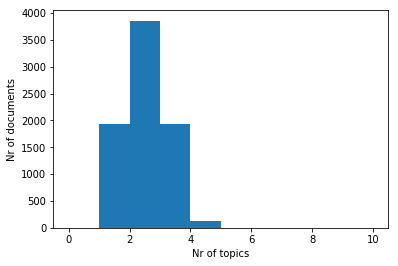

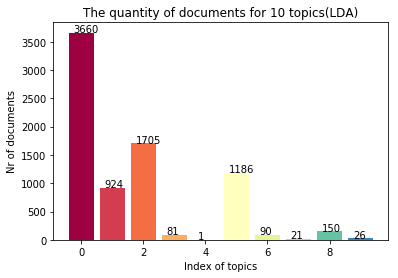

[■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■▶]100.00%


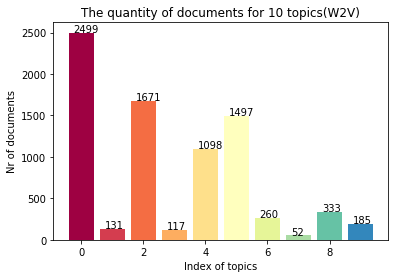

coherence : 0.45057170511967237


In [67]:
dictionary = gensim.corpora.Dictionary.load('dictionary.dict')
corpus_tfidf = gensim.corpora.MmCorpus('corpus.mm')
index_coherence=[]
for num in range(6,11):
    loading = LdaModel.load('lda'+str(num)+'.model')
    print("Num_topic : "+str(num))
 
    for idx in range(num):
        # Print the first 20 most representative topics
        print("Topic #%s:" % idx, loading.print_topic(idx, 18))
        
    thetas=np.array([np.array(loading[c]) for c in corpus_tfidf])
    relation_num_topic_per_document(thetas,num)
    relation_num_document_per_topic(thetas,num)
    relation_num_document_per_topic_w2v(loading,num)
    
    cmm = CoherenceModel(model=loading, texts=token_text, dictionary=dictionary, coherence='c_v')
    coh = cmm.get_coherence()
    index_coherence.append(coh)
    print ("coherence : "+str(coh))
    print("=" * 20)

Num_topic : 14
Topic #0: 0.001*"cdiscount" + 0.001*"entrepôt" + 0.001*"noron" + 0.001*"blockchain" + 0.001*"supply" + 0.001*"warehouse" + 0.001*"chain" + 0.001*"continental" + 0.001*"grenoblois" + 0.001*"swave" + 0.001*"e-commerçants" + 0.001*"cce"
Topic #1: 0.001*"suisse" + 0.001*"mbs" + 0.001*"million" + 0.001*"mohammed" + 0.001*"euro" + 0.001*"consécutive" + 0.001*"genève" + 0.001*"bretagne" + 0.001*"fonds" + 0.001*"sportif" + 0.001*"prince" + 0.001*"heure"
Topic #2: 0.001*"cleantech" + 0.001*"quéré" + 0.001*"algérien" + 0.001*"n26" + 0.001*"sylvain" + 0.001*"bretagne" + 0.001*"taxe" + 0.001*"delahaye" + 0.001*"championnat" + 0.001*"â" + 0.001*"heure" + 0.001*"mauléon"
Topic #3: 0.002*"cook" + 0.002*"wework" + 0.002*"agromousquetaires" + 0.002*"1kubator" + 0.001*"oise" + 0.001*"yonne" + 0.001*"vitré" + 0.001*"cmn" + 0.001*"ouest" + 0.001*"mixité" + 0.001*"blockchain" + 0.001*"bouygues"
Topic #4: 0.002*"french" + 0.002*"microsoft" + 0.002*"startups" + 0.002*"tech" + 0.002*"france" + 

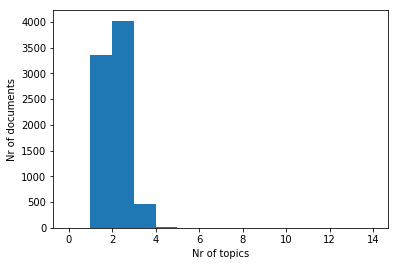

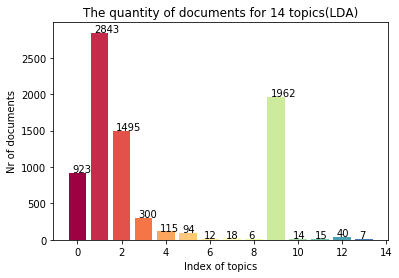

[■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■■▶]100.00%


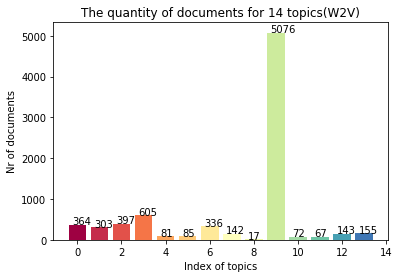

In [95]:
num=14
loading = LdaModel.load('lda'+str(num)+'.model')
print("Num_topic : "+str(num))
 
for idx in range(num):
    # Print the first 20 most representative topics
    print("Topic #%s:" % idx, loading.print_topic(idx, 12))
        
thetas=np.array([np.array(loading[c]) for c in corpus_tfidf])
relation_num_topic_per_document(thetas,num)
relation_num_document_per_topic(thetas,num)
relation_num_document_per_topic_w2v(loading,num)

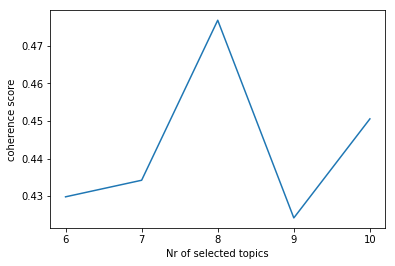

In [74]:
plt.plot(range(6,11),index_coherence)
plt.xticks(range(6,11))
plt.ylabel('coherence score')
plt.xlabel('Nr of selected topics')
plt.savefig('coherence.pdf')
plt.show()

In [48]:
def pre_new(doc):
    split = tokenize(doc)
    return dictionary.doc2bow(split)

In [53]:
new = pd.DataFrame(loading[pre_new("je suis une étudiante. Je fais de l'école polytechnique. Mon père est Macron")],columns=['id','prob']).sort_values('prob',ascending=False)
new['topic'] = new['id'].apply(loading.print_topic)
new

,id,prob,topic
5,5,0.849923,"0.001*""pari"" + 0.001*""france"" + 0.001*""ministr..."
6,6,0.016679,"0.001*""école"" + 0.001*""tourisme"" + 0.001*""espa..."
0,0,0.016677,"0.001*""numérique"" + 0.001*""heure"" + 0.001*""eur..."
2,2,0.016676,"0.002*""france"" + 0.002*""client"" + 0.001*""pari""..."
8,8,0.016675,"0.004*""heure"" + 0.002*""permanence"" + 0.002*""sa..."
1,1,0.016674,"0.002*""niort"" + 0.001*""gmt"" + 0.001*""cook"" + 0..."
7,7,0.016674,"0.004*""prince"" + 0.003*""mbs"" + 0.003*""héritier..."
9,9,0.016674,"0.003*""oréal"" + 0.001*""quéré"" + 0.001*""beauté""..."
4,4,0.016674,"0.001*""modiface"" + 0.001*""fainéant"" + 0.001*""n..."
3,3,0.016674,"0.001*""gard"" + 0.001*""vegas"" + 0.001*""las"" + 0..."


# Export html document

In [41]:
import pyLDAvis.gensim
import gensim
pyLDAvis.enable_notebook()

In [96]:
def lda_vis(num):
    dictionary = gensim.corpora.Dictionary.load('dictionary.dict')
    corpus = gensim.corpora.MmCorpus('corpus.mm')
    lda = models.ldamodel.LdaModel.load('lda'+str(num)+'.model')
    vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary)
    pyLDAvis.save_html(vis, 'lda'+str(num)+'.html')
    return 0
 
 
if __name__ == '__main__':
    for i in range(6,11):
        lda_vis(i)
        print("lda"+str(i)+" finished!")

C:\Users\ZTY\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


lda6 finished!


C:\Users\ZTY\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


lda7 finished!


C:\Users\ZTY\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


lda8 finished!


C:\Users\ZTY\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


lda9 finished!


C:\Users\ZTY\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


lda10 finished!
